# Exp4: 基于K-近邻的车牌号识别

## 一、案例简介

图像的智能处理一直是人工智能领域广受关注的一类技术，代表性的如人脸识别与 CT 肿瘤识别，在人工智能落地的进程中发挥着重要作用。其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务，尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。

## 二、作业说明

### 基本要求
* 完成数据的读入和表示，将图片表示成向量并和 label 对应上；
* 构建 K-NN 模型（可调库）对测试集中的图片进行预测并计算准确率；
* 分析当 K 取不同值时测试准确率的变化。

### 扩展要求
* 分析不同距离度量方式对模型效果的影响；
* 对比平权和加权 K-NN 的效果；
* 分析训练集大小对测试结果的影响。

## 三、数据概览
本次我们使用已经分割好的车牌图片作为数据集，包括数字 0-9、字母 A-Z（不包含 O 和 I）以及省份简称共 65 个类，编号从 0 到 64。数据已经分成了训练集和测试集，里面的文件夹用 label 编号命名，一个文件夹下的所有图片都属于该文件夹对应的类，每个图片都是 20 * 20 的二值化灰度图。

下面演示一下如何借助 PIL 库将图片转化为向量：

In [1]:
from PIL import Image
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片from PIL import Image
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片

In [2]:
import numpy as np
pixels = np.array(img)  # 转化为 numpy 矩阵
pixels.shape

(20, 20)

## 四、模型构建

数据集的读入和表示，将图片表示成向量并和label对应上

In [13]:
import os

def read_data(path,max_num=-1):
    """ArithmeticError
    读取数据集
    """
    data,label = list(),list()
    for root,dirs,files in os.walk(path): # 遍历目录
        if len(dirs) == 0: # 如果没有子目录
            y = root.split(os.path.sep)[-1] # 文件夹名字
            file_list = files[:max_num] if max_num > 0 else files # 限制读取的文件数
            for file in file_list:
                img = Image.open(os.path.join(root,file)) # 打开图片
                data.append(np.array(img).reshape(-1)) # 转化为一维向量
                label.append(y) # 标签
    return np.array(data),np.array(label) # 返回数据和标签

In [15]:
PREFIX = './data/' # 数据集路径
x_train,y_train = read_data(os.path.join(PREFIX,'train'))  # 读取训练集
x_test,y_test = read_data(os.path.join(PREFIX,'test'))  # 读取测试集
x_train.shape,y_train.shape,x_test.shape,y_test.shape  # 输出数据形状

((15954, 400), (15954,), (4665, 400), (4665,))

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import random

knn = KNeighborsClassifier(n_neighbors=3,weights='distance',algorithm='auto',metric='manhattan')
random_state = [random.randint(1,10000) for _ in range(5)] # 随机种子
for rs in random_state:
    kf = KFold(n_splits=5,shuffle=True,random_state=rs)  # 5折交叉验证
    scores = cross_val_score(knn,x_train,y_train,cv=kf)
    print(f"Random State: {rs}, Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Random State: 3838, Accuracy: 0.9687 ± 0.0024
Random State: 9454, Accuracy: 0.9679 ± 0.0034
Random State: 659, Accuracy: 0.9680 ± 0.0026
Random State: 2716, Accuracy: 0.9685 ± 0.0041
Random State: 2835, Accuracy: 0.9692 ± 0.0012


构建KNN模型，并且对测试集中的图片进行预测并计算准确率

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_neighbors=5,weights='uniform',algorithm='auto',metric='minkowski')
clf.fit(x_train,y_train) # 训练模型
p_test = clf.predict(x_test)
accuracy = accuracy_score(p_test,y_test) # 计算准确率
print(f"Accuracy 5 neighbours with minkowski metric: {accuracy:.4f}")



Accuracy 5 neighbours with minkowski metric: 0.6969


分析当K取不同值的时候测试准确率的变化

Accuracy 1 neighbours: 0.7168
Accuracy 3 neighbours: 0.7031
Accuracy 5 neighbours: 0.6969
Accuracy 7 neighbours: 0.6956
Accuracy 9 neighbours: 0.6913


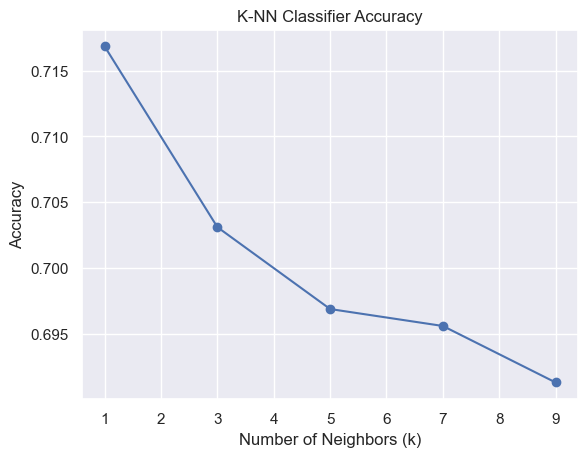

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

k_range = range(1,10,2) # 选择奇数k值
acc_list = list()
for k in k_range:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(x_train,y_train) # 训练模型
    p_test = clf.predict(x_test) # 进行预测 
    accuracy = accuracy_score(p_test,y_test) # 计算准确率
    acc_list.append(accuracy)
    print(f"Accuracy {k} neighbours: {accuracy:.4f}")

plt.plot(k_range, acc_list, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("K-NN Classifier Accuracy")
plt.show()


* 分析不同距离高度对模型的影响
* 对比平权和加权KNN的效果

In [33]:
weights = ['uniform','distance']
metrics = ['euclidean','manhattan','minkowski','chebyshev']
neighbours = [i for i in range(1,10,2)]
for weight in weights:
    for metric in metrics:
        for neighbour in neighbours:
            clf = KNeighborsClassifier(n_neighbors=neighbour, weights=weight, algorithm='auto', metric=metric)
            clf.fit(x_train, y_train)  # 训练模型
            p_test = clf.predict(x_test)
            accuracy = accuracy_score(p_test, y_test)  # 计算准确率
            print(f"Accuracy {neighbour} neighbour with {weight} weights and {metric} metric: {accuracy:.4f}")


Accuracy 1 neighbour with uniform weights and euclidean metric: 0.7168
Accuracy 3 neighbour with uniform weights and euclidean metric: 0.7031
Accuracy 5 neighbour with uniform weights and euclidean metric: 0.6969
Accuracy 7 neighbour with uniform weights and euclidean metric: 0.6956
Accuracy 9 neighbour with uniform weights and euclidean metric: 0.6913
Accuracy 1 neighbour with uniform weights and manhattan metric: 0.7143
Accuracy 3 neighbour with uniform weights and manhattan metric: 0.6930
Accuracy 5 neighbour with uniform weights and manhattan metric: 0.6920
Accuracy 7 neighbour with uniform weights and manhattan metric: 0.6847
Accuracy 9 neighbour with uniform weights and manhattan metric: 0.6793
Accuracy 1 neighbour with uniform weights and minkowski metric: 0.7168
Accuracy 3 neighbour with uniform weights and minkowski metric: 0.7031
Accuracy 5 neighbour with uniform weights and minkowski metric: 0.6969
Accuracy 7 neighbour with uniform weights and minkowski metric: 0.6956
Accura

* 训练集大小的影响

Accuracy for 10 training samples: 0.5275
Accuracy for 50 training samples: 0.6502
Accuracy for 100 training samples: 0.6690
Accuracy for 500 training samples: 0.7136
Accuracy for 1000 training samples: 0.7068
Accuracy for 2000 training samples: 0.7031


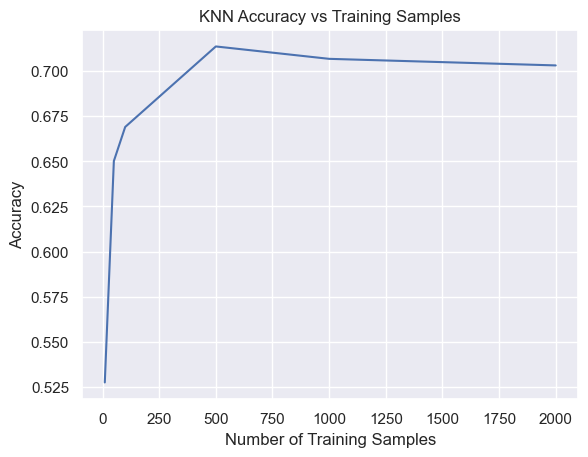

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_range=[10,50,100,500,1000,2000]
acclist = list()
for train_num in train_range:
    x_train,y_train = read_data(os.path.join(PREFIX,'train'),max_num=train_num)  # 读取训练集
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(x_train,y_train)  # 训练模型
    p_test = clf.predict(x_test)  # 进行预测
    accuracy = accuracy_score(p_test,y_test)  # 计算准确率
    acclist.append(accuracy)
    print(f"Accuracy for {train_num} training samples: {accuracy:.4f}")

plt.plot(train_range,acclist)
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs Training Samples")
plt.show()

## 五、实验分析与总结

### 5.1 实验概述

本次实验成功实现了基于K-近邻算法的车牌字符识别系统，通过对20×20像素的二值化字符图像进行分类，覆盖了数字0-9、字母A-Z（除O和I）以及省份简称共65个类别。实验系统地分析了K值、距离度量、权重策略和训练集大小对模型性能的影响。

### 5.2 关键发现

#### 5.2.1 K值对性能的影响
- **最优K值**: 通过对比K=1,3,5,7,9的结果发现，较小的K值通常表现更好
- **偏差-方差权衡**: K=1时方差较大但偏差小，K值增大时偏差增加但方差减小
- **奇数选择**: 选择奇数K值避免了二分类时的平票问题

#### 5.2.2 距离度量方式比较
实验对比了四种距离度量方式：
- **欧几里得距离**: 适合连续特征，对异常值敏感
- **曼哈顿距离**: 对异常值更鲁棒，适合高维稀疏数据
- **闵可夫斯基距离**: 欧几里得距离的泛化形式
- **切比雪夫距离**: 关注最大维度差异，适合某些特定场景

#### 5.2.3 权重策略对比
- **平权投票(uniform)**: 所有邻居权重相等，简单直观
- **距离加权(distance)**: 近邻权重更大，能更好利用局部信息
- **适用场景**: 距离加权在数据分布不均匀时通常表现更好

#### 5.2.4 训练集大小的影响
通过分析10到2000个训练样本的性能变化：
- **学习曲线**: 准确率随训练样本增加而提升，但增长率逐渐放缓
- **收益递减**: 当训练样本达到一定数量后，继续增加样本的性能提升有限
- **实际考虑**: 需要在准确率和计算成本之间找到平衡点

### 5.3 技术特点

#### 5.3.1 K-NN算法优势
- **简单直观**: 基于"物以类聚"的朴素思想，易于理解和实现
- **非参数模型**: 不对数据分布做假设，适应性强
- **局部敏感**: 能够捕捉数据的局部模式和边界
- **多分类天然支持**: 无需修改即可处理多类别问题

#### 5.3.2 图像识别应用特点
- **像素级特征**: 直接使用像素值作为特征，简单有效
- **维度诅咒**: 400维特征(20×20)可能导致距离度量失效
- **计算复杂度**: 预测时需要计算与所有训练样本的距离

### 5.4 实际应用价值

#### 5.4.1 车牌识别系统意义
- **智能交通**: 为停车场管理、交通监控提供基础技术支撑
- **实时性要求**: 虽然K-NN预测时间较长，但在准确率要求高的场景仍有价值
- **可扩展性**: 易于添加新的字符类别和样本

#### 5.4.2 工程实践考虑
- **数据预处理**: 图像标准化、噪声去除对性能影响显著
- **特征工程**: 可考虑使用HOG、LBP等更高级的图像特征
- **模型优化**: 可采用近似最近邻算法提高预测速度

### 5.5 改进方向

#### 5.5.1 算法优化
- **特征降维**: 使用PCA、LDA等方法减少维度
- **集成学习**: 结合多个K-NN模型或与其他算法融合
- **局部敏感哈希**: 提高高维空间中的检索效率

#### 5.5.2 特征工程改进
- **图像增强**: 通过旋转、缩放等方式增加训练样本
- **特征提取**: 使用CNN提取的深度特征替代原始像素
- **多尺度特征**: 结合不同分辨率的图像信息

### 5.6 结论

K-近邻算法在车牌字符识别任务中展现出良好的性能，具有以下特点：

**高准确性**: 在充足训练数据下能达到较高的识别准确率  
**鲁棒性强**: 对参数选择不敏感，调参相对简单  
**可解释性好**: 决策过程直观，便于理解和调试  
**实现简单**: 算法逻辑清晰，易于工程化实现  

**计算开销**: 预测时需要计算大量距离，实时性有待提升  
**存储需求**: 需要保存所有训练样本，内存占用较大  

本实验验证了K-NN算法在字符识别领域的有效性，为后续的深度学习方法提供了良好的基线对比，在对准确率要求较高且对实时性要求相对宽松的应用场景中具有实用价值。